In [15]:
import pandas as pd
import numpy as np 
import os
import csv
import statsmodels.formula.api as smf
import statsmodels.api as sm

anoi = 2022 # especificar o ano inicial a ser estudado
anof = 2024 # especificar o ano final a ser estudado
anos = []
for i in range(anof-anoi+1): # cria uma lista dos anos a serem estudados 
    anos.append(anof-(i))


df = pd.DataFrame()

In [16]:
#Abre todos os arquivos e monta o data frame 

for ano in anos:

    pastadados = f'anac_{ano}'
    nome_arquivos = os.listdir(pastadados)

    Primeiro_Lido = False
    for i in nome_arquivos: 

        with open(pastadados+'/'+str(i), mode = 'r', encoding = 'latin-1') as arq: #descobre o separador do arquivo
            sniff = (csv.Sniffer().sniff(arq.readline())).delimiter

        if not Primeiro_Lido:
            arquivo = pd.read_csv(pastadados+'/'+str(i),sep = sniff, encoding='latin-1', decimal=',', low_memory=False) # Lê o primeiro
            arquivo.columns = ['ANO','MES','EMPRESA','ORIGEM','DESTINO','TARIFA','ASSENTOS'] #padroniza os arquivos para o mesmo cabeçalho
            Primeiro_Lido = True

        else:
            arquivo_corrido = pd.read_csv(pastadados+'/'+str(i),sep = sniff, encoding='latin-1', decimal=',',low_memory=False) 
        

            while len(arquivo_corrido.columns)>7:
                del arquivo_corrido[f'{arquivo_corrido.columns[0]}'] #retira colunas vazias ou de contagem de linhas

        
                

            arquivo_corrido.columns = ['ANO','MES','EMPRESA','ORIGEM','DESTINO','TARIFA','ASSENTOS'] #padroniza os arquivos para o mesmo cabeçalho
            arquivo = pd.concat([arquivo, arquivo_corrido]) 

    df = pd.concat([df, arquivo]) 
    

df['TARIFA'] = pd.to_numeric(df['TARIFA'], errors='coerce') # define a coluna tarifa como número e não objeto


df['RECEITA'] = df['TARIFA']*df['ASSENTOS'] #cria coluna de receita


aeroportos_sp_icao = ['SBSP', 'SBGR']
aeroportos_rj_icao = ['SBRJ', 'SBGL']

#filtra a rota RJ-SP, principal rota da aviação comercial (rota trabalhada no projeto)

tabela_filtrada = df[df['ORIGEM'].isin(aeroportos_rj_icao) & df['DESTINO'].isin(aeroportos_sp_icao)]
tabela_filtrado2= df[df['ORIGEM'].isin(aeroportos_sp_icao) & df['DESTINO'].isin(aeroportos_rj_icao)]

dfrota = pd.concat([tabela_filtrada, tabela_filtrado2]) 

#Data Frame principal a ser utilizado
dfrota

,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA,ASSENTOS,RECEITA
78452,2024,1,AZU,SBGL,SBGR,116.50,2,233.00
78453,2024,1,AZU,SBGL,SBGR,117.90,2,235.80
78454,2024,1,AZU,SBGL,SBGR,118.14,3,354.42
78455,2024,1,AZU,SBGL,SBGR,143.91,4,575.64
78456,2024,1,AZU,SBGL,SBGR,151.10,6,906.60
...,...,...,...,...,...,...,...,...
320717,2022,12,TAM,SBSP,SBRJ,3190.90,10,31909.00
320718,2022,12,TAM,SBSP,SBRJ,3199.00,1,3199.00
320719,2022,12,TAM,SBSP,SBRJ,3432.99,1,3432.99
320720,2022,12,TAM,SBSP,SBRJ,5260.11,2,10520.22


In [17]:
#----------------------------Gráfico 1: Tarifa Média Anual ----------------------------------------------

# monta o df_1 - (Tarifa Media Mensal Por Ano)

df_1 = dfrota.groupby(['ANO','ORIGEM', 'DESTINO', 'EMPRESA', 'MES'])[['RECEITA', 'ASSENTOS']].sum()
df_1['TARIFA_MEDIA_MENSAL'] = df_1['RECEITA'] / df_1['ASSENTOS']


df_1 = df_1.reset_index()[['ANO', 'MES','EMPRESA', 'ORIGEM', 'DESTINO' ,'TARIFA_MEDIA_MENSAL' ]]

df_1['ANO'] = df_1['ANO'].astype(int)
df_1['MES'] = df_1['MES'].astype(int)   

df_1

,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA_MEDIA_MENSAL
0,2022,5,AZU,SBGL,SBGR,953.328571
1,2022,9,AZU,SBGL,SBGR,2001.600000
2,2022,11,AZU,SBGL,SBGR,343.800000
3,2022,12,AZU,SBGL,SBGR,2158.150000
4,2022,1,GLO,SBGL,SBGR,505.261414
...,...,...,...,...,...,...
788,2024,8,TAM,SBSP,SBRJ,439.809928
789,2024,9,TAM,SBSP,SBRJ,429.933877
790,2024,10,TAM,SBSP,SBRJ,530.048853
791,2024,11,TAM,SBSP,SBRJ,459.576693


In [18]:
#Arrumando o dataset
combu = pd.read_excel('combustiveis-aviacao-regioes.xlsx')

combustiveis = combu[combu['REGIÃO'] == 'SUDESTE']

querosene = combustiveis[combustiveis['PRODUTO'] == 'QUEROSENE DE AVIAÇÃO']

querosene['MÊS'] = pd.to_datetime(querosene['MÊS']) #Formata a coluna da data, seperando em ano e mes 
querosene['ANO'] = querosene['MÊS'].dt.year
querosene['MES'] = querosene['MÊS'].dt.month

qav = querosene[['ANO', 'MES', 'UNIDADE DE MEDIDA', 'PREÇO MÉDIO DE DISTRIBUIÇÃO']]

qav

,ANO,MES,UNIDADE DE MEDIDA,PREÇO MÉDIO DE DISTRIBUIÇÃO
581,2018,11,R$/l,3.492233
582,2018,12,R$/l,3.220913
583,2019,1,R$/l,2.903441
584,2019,2,R$/l,2.841723
585,2019,3,R$/l,2.942767
...,...,...,...,...
659,2025,5,R$/l,4.471988
660,2025,6,R$/l,4.147937
661,2025,7,R$/l,4.281472
662,2025,8,R$/l,4.461266


In [19]:
# Supondo que o segundo dataframe se chame df_combustivel
# e tenha colunas: ['ANO', 'MES', 'PREÇO MÉDIO DE DISTRIBUIÇÃO']

df_f = df_1.merge(
    qav[['ANO', 'MES', 'PREÇO MÉDIO DE DISTRIBUIÇÃO']],
    on=['ANO', 'MES'],
    how='left'
)

df_f.rename(columns={'PREÇO MÉDIO DE DISTRIBUIÇÃO': 'PRECO_MEDIO_DISTRIBUICAO'}, inplace=True)

df_f

,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA_MEDIA_MENSAL,PRECO_MEDIO_DISTRIBUICAO
0,2022,5,AZU,SBGL,SBGR,953.328571,6.123784
1,2022,9,AZU,SBGL,SBGR,2001.600000,6.198058
2,2022,11,AZU,SBGL,SBGR,343.800000,6.506513
3,2022,12,AZU,SBGL,SBGR,2158.150000,6.118435
4,2022,1,GLO,SBGL,SBGR,505.261414,4.434005
...,...,...,...,...,...,...,...
788,2024,8,TAM,SBSP,SBRJ,439.809928,4.948092
789,2024,9,TAM,SBSP,SBRJ,429.933877,4.716770
790,2024,10,TAM,SBSP,SBRJ,530.048853,4.316450
791,2024,11,TAM,SBSP,SBRJ,459.576693,4.386880


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import openpyxl
import warnings
warnings.filterwarnings("ignore")

In [21]:
##Codificar as variáveis qualitativas
df_f.replace({'EMPRESA':{1:'AZU',2:'TAM',3:'GLO'}} , inplace=True)

df_f['d_AZU'] = np.where(df_f['EMPRESA'] == 'AZU', 1, 0)
df_f['d_TAM'] = np.where(df_f['EMPRESA'] == 'TAM', 1, 0)
df_f['d_GLO'] = np.where(df_f['EMPRESA'] == 'GLO', 1, 0)
df_f.sample(10)

,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA_MEDIA_MENSAL,PRECO_MEDIO_DISTRIBUICAO,d_AZU,d_TAM,d_GLO
340,2023,6,GLO,SBGR,SBGL,382.733108,4.157593,0,0,1
461,2023,4,PTB,SBRJ,SBSP,1044.137895,5.229061,0,0,0
482,2023,11,AZU,SBSP,SBGL,1202.890000,5.241839,1,0,0
313,2023,6,GLO,SBGL,SBSP,237.250467,4.157593,0,0,1
405,2023,8,AZU,SBRJ,SBGR,567.603371,4.290628,1,0,0
373,2023,3,GLO,SBGR,SBRJ,487.280302,5.510526,0,0,1
180,2022,4,PTB,SBRJ,SBSP,1272.333333,5.761856,0,0,0
252,2022,2,PTB,SBSP,SBRJ,608.842644,4.799496,0,0,0
136,2022,8,GLO,SBRJ,SBGR,724.022649,6.844366,0,0,1
94,2022,2,GLO,SBGR,SBRJ,389.541791,4.799496,0,0,1


In [9]:
df_f.columns

Index(['ANO', 'MES', 'EMPRESA', 'ORIGEM', 'DESTINO', 'TARIFA_MEDIA_MENSAL',
       'PRECO_MEDIO_DISTRIBUICAO'],
      dtype='object')

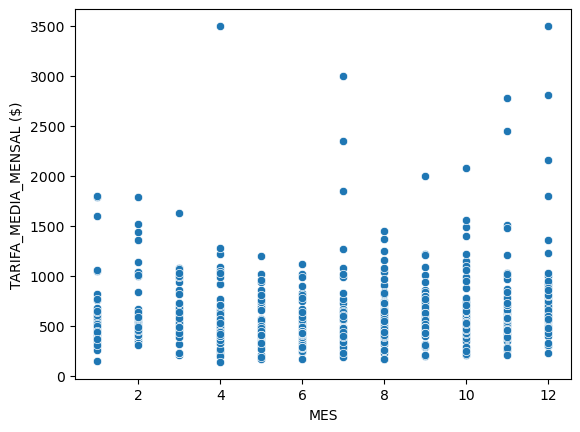

In [11]:
# Estatística descritiva Descritiva

sns.scatterplot(x='MES', y='TARIFA_MEDIA_MENSAL', data=df_f)
plt.xlabel('MES')
plt.ylabel('TARIFA_MEDIA_MENSAL ($)')
plt.show()


In [22]:
df_f.columns

Index(['ANO', 'MES', 'EMPRESA', 'ORIGEM', 'DESTINO', 'TARIFA_MEDIA_MENSAL',
       'PRECO_MEDIO_DISTRIBUICAO', 'd_AZU', 'd_TAM', 'd_GLO'],
      dtype='object')

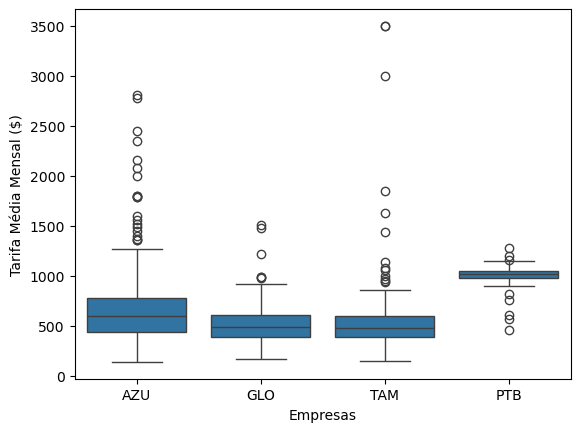

In [26]:
sns.boxplot(x='EMPRESA', y='TARIFA_MEDIA_MENSAL', data=df_f)
plt.xlabel('Empresas')
plt.ylabel('Tarifa Média Mensal ($)')
plt.show()